In [6]:
from mimic.utilities.utilities import *
from mimic.model_infer import *
from mimic.model_simulate import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## Simulate some time course data from the gMLV

### Five species, six metabolites, single time course
This model assumes metabolite production is associated with abundance:  dS/dt = alpha X <br>
Note that this model needs rethinking as it cannot handle negative productivities <br>
In this simple example we don't need to infer the time course. We just linearize and estimate the elements of alpha with Lasso<br>
Number of metabolites is 6 here

Model parameters:
Model: gMLV
num_species: 5
num_metabolites: 6
num_perturbations: 0
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.    0.    0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.    0.    0.    0.   -0.2 ]]
beta: [[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0. ]
 [ 0.   0.   0.   0.   0. ]]
epsilon: []
Using the following parameters for gMLV simulation: {'num_species': 5, 'num_metabolites': 6, 'num_perturbations': 0, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.1 ,  0.  ,  0.05,  0.  ],
       [ 0.  ,  0.  , -0.15,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.01,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.2 ]]), 'beta': array([[ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  1. ],
       [ 0. ,  0. ,  0.

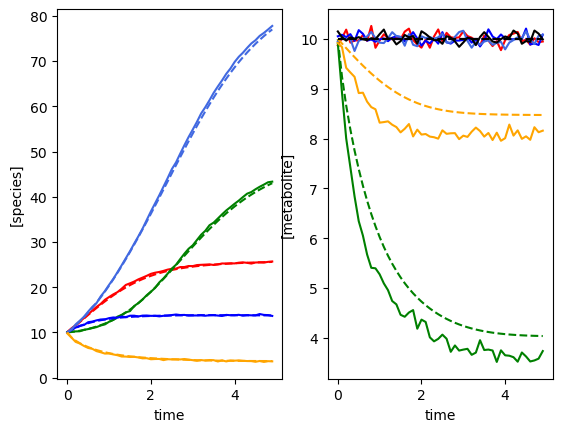

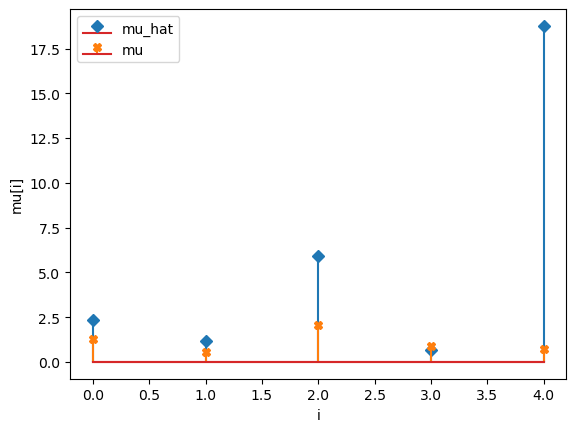

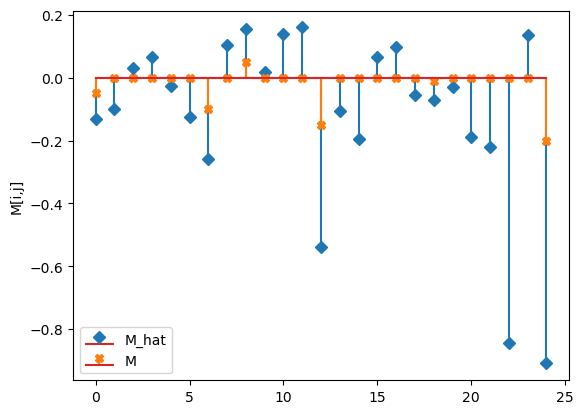

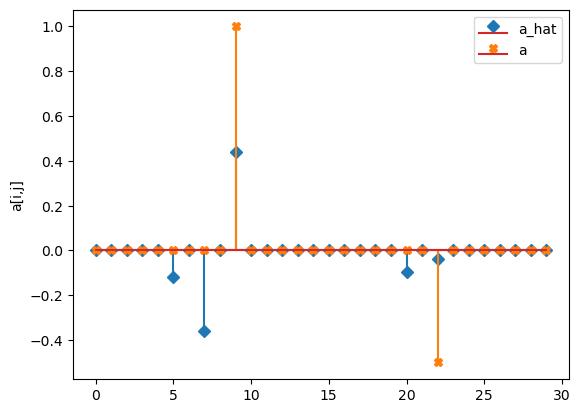

In [8]:
# Simulate some microbiota and metabolites
set_all_seeds(1234)

# SETUP MODEL
# establish size of model
num_species = 5
num_metabolites = 6

# construct interaction matrix
# TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
# M[0,2] = -0.025
M[1, 3] = 0.05
# M[4,0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# construct metabolite production matrix
alpha = np.zeros((num_metabolites, num_species))
alpha[1, 4] = 1
alpha[4, 2] = -0.5

# instantiate simulator
simulator = sim_gMLV(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu,
                     beta=alpha)
simulator.print_parameters()

# PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)

times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, _, _, _ = simulator.simulate(
    times=times, sy0=np.hstack((init_species, init_metabolites)))

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
sobs = sobs + np.random.normal(loc=0, scale=0.1, size=sobs.shape)

# plot simulation
# plot_gMLV(yobs, sobs, times)

# PERFORM REGRESSION
# fit growth first
# linearise
X, F = linearize_time_course_16S(yobs, times)
# print(f"n: {num_species * F.shape[0]}, p: {num_species + num_species ** 2}")

# get the best lambda/alpha values on a grid via cross validation
a0, a1 = fit_alpha_Ridge1(X, F, num_species=num_species, n_a0=20, n_a1=20)

# do final fit
mu_h, M_h = do_final_fit_Ridge1(X, F, num_species, a0, a1)

# fit metabolite production
# Linearize this problem
G, S = linearise_time_course_metabolites(sobs, yobs, times)

# get the best lambda/alpha value on a grid via cross validation
#a_min, a_se = fit_alpha_lasso(G, S, n_a=20)
#model = Lasso(fit_intercept=False, max_iter=10000, alpha=a_min)

# perform final fit
model.fit(G, S)
alpha_h = model.coef_

predictor = sim_gMLV(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h,
                     beta=alpha_h)
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(
    times=times, sy0=np.hstack((init_species, init_metabolites)))

# PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)

compare_params(mu=(mu, mu_h), M=(M, M_h), alpha=(alpha, alpha_h))